# Análisis del Comportamiento del Usuario

Analizaremos el comportamiento de los usuarios dentro de la aplicación de una empresa emergente dedicada a la venta de productos alimenticios. El objetivo principal es estudiar cómo interactúan los usuarios con la aplicación y qué tan efectiva es en convertir visitas en compras.

El analisis se divide en dos partes principales:

1. **Análisis del embudo de ventas**: Se investigará cómo los usuarios avanzan a través de diferentes etapas de interacción dentro de la aplicación, identificando los puntos donde se pierden usuarios antes de llegar a la compra.

2. **Análisis del experimento A/A/B**: Se evaluará un experimento donde los usuarios fueron divididos en tres grupos: dos grupos de control (con la fuente original) y un grupo experimental (con una fuente nueva). El propósito es determinar si el cambio en la fuente tiene un impacto significativo en el comportamiento del usuario.

Se utilizará un solo conjunto de datos para ambos análisis. Este análisis será realizado de forma estructurada en un entorno Jupyter Notebook, donde cada paso incluirá una explicación previa, el código correspondiente y una breve conclusión.


## Paso 1 – Carga de datos e inspección inicial

En este paso, cargaremos el archivo de datos `logs_exp_us.csv` que contiene los registros de eventos de usuario dentro de la aplicación. El objetivo es asegurarnos de que los datos se cargan correctamente y obtener una primera impresión general del contenido del dataset.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest


# Cargar el archivo usando el separador de tabulaciones
df = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t', dtype={'timestamp': str})

# Mostrar las primeras filas del dataframe
df.head()


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### Conclusión del Paso 1

Los datos se han cargado correctamente y podemos ver las primeras filas del conjunto de datos. A partir de esto, podemos observar que las columnas principales son `EventName`, `DeviceIDHash`, `EventTimestamp` y `ExpId`. En el siguiente paso, prepararemos estos datos para el análisis detallado.


## Paso 2 – Preparación de los datos para el análisis

En este paso, se preparan los datos para facilitar el análisis posterior. Esto incluye:
- Renombrar las columnas para que sean más legibles.
- Comprobar los tipos de datos y la existencia de valores nulos.
- Convertir los datos de marca de tiempo a un formato de fecha legible.
- Agregar columnas separadas para la fecha completa y la fecha sin hora.


In [2]:
# Renombrar columnas
df.columns = ['event', 'user_id', 'timestamp', 'group']

# Convertir timestamp desde formato Unix (en segundos) a datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Crear columna solo con la fecha
df['date'] = df['timestamp'].dt.date

# Verificar tipos y primeras filas
print(df.info())
df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      244126 non-null  object        
 1   user_id    244126 non-null  int64         
 2   timestamp  244126 non-null  datetime64[ns]
 3   group      244126 non-null  int64         
 4   date       244126 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB
None


,event,user_id,timestamp,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


### Conclusión del Paso 2

La columna `timestamp` fue correctamente convertida desde el formato Unix en segundos a un tipo de dato `datetime`. También se creó la columna `date`, que contiene únicamente la fecha. Con esto, los datos están listos para el análisis temporal y del comportamiento de usuario.



## Paso 3 – Estudio y comprobación general de los datos

En este paso se realiza un análisis exploratorio para responder las siguientes preguntas:

- ¿Cuántos eventos hay en total?
- ¿Cuántos usuarios únicos se registran?
- ¿Cuál es el promedio de eventos por usuario?


In [3]:
# ¿Cuántos eventos hay en los registros?
total_eventos = df.shape[0]

# ¿Cuántos usuarios hay en los registros?
usuarios_unicos = df['user_id'].nunique()

# ¿Cuál es el promedio de eventos por usuario?
promedio_eventos_por_usuario = total_eventos / usuarios_unicos

# Mostrar resultados
print(f"Total de eventos en los registros: {total_eventos}")
print(f"Total de usuarios únicos: {usuarios_unicos}")
print(f"Promedio de eventos por usuario: {promedio_eventos_por_usuario:.2f}")


Total de eventos en los registros: 244126
Total de usuarios únicos: 7551
Promedio de eventos por usuario: 32.33


### Paso 3 – Estudio y comprobación general de los datos (Parte 1)

#### ¿Cuántos eventos hay en los registros?
- Total de eventos: **244,126**

#### ¿Cuántos usuarios hay en los registros?
- Total de usuarios únicos: **7,551**

#### ¿Cuál es el promedio de eventos por usuario?
- Promedio: **32.33 eventos por usuario**

### ¿Qué periodo de tiempo cubren los datos?



In [4]:
# Obtener fecha mínima y máxima
fecha_min = df['timestamp'].min()
fecha_max = df['timestamp'].max()

# Mostrar resultados
print(f"Fecha mínima en los datos: {fecha_min}")
print(f"Fecha máxima en los datos: {fecha_max}")

Fecha mínima en los datos: 2019-07-25 04:43:36
Fecha máxima en los datos: 2019-08-07 21:15:17


El rango temporal de los eventos registrados en el dataset va desde el 25 de julio de 2019 hasta el 7 de agosto de 2019. Esto nos da un periodo de análisis de 14 días completos, lo cual es adecuado para estudiar el comportamiento de los usuarios dentro de un periodo limitado de actividad.


### Histograma por fecha y hora

Para evaluar si los datos están distribuidos de manera uniforme a lo largo del periodo registrado, se trazará un histograma de eventos por fecha. Esto permitirá identificar si hay días con menos actividad o posibles registros incompletos al inicio o al final del periodo.


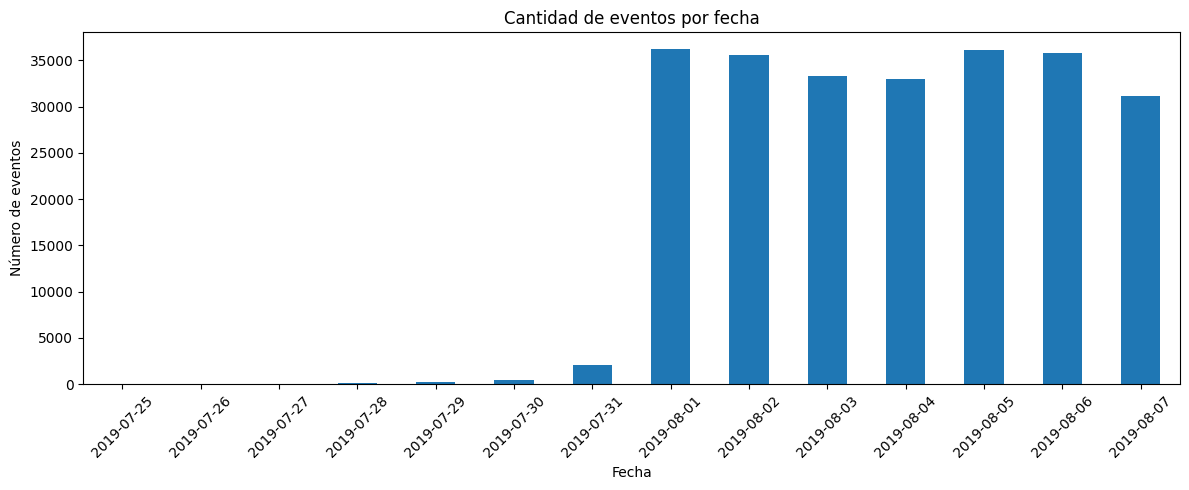

In [5]:
# Crear una nueva columna con solo la fecha (si no existe ya)
df['date'] = df['timestamp'].dt.date

# Contar eventos por día
eventos_por_fecha = df.groupby('date').size()

# Graficar histograma
plt.figure(figsize=(12, 5))
eventos_por_fecha.plot(kind='bar')
plt.title('Cantidad de eventos por fecha')
plt.xlabel('Fecha')
plt.ylabel('Número de eventos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Conclusión del histograma por fecha

El histograma muestra que los registros entre el **25 y el 30 de julio de 2019** tienen una cantidad muy baja de eventos, lo que sugiere que los datos de esos días son incompletos o residuales.

A partir del **1 de agosto de 2019**, la actividad se vuelve estable y consistente, lo que indica que el sistema comenzó a registrar datos de forma completa en esa fecha. Por lo tanto, se recomienda ignorar los datos previos al 1 de agosto para evitar sesgos en el análisis.

### Periodo confiable para análisis: **01/08/2019 al 07/08/2019**


In [6]:
# Filtrar datos desde el 1 de agosto de 2019 en adelante
fecha_inicio_valida = pd.to_datetime('2019-08-01')
df_filtrado = df[df['timestamp'] >= fecha_inicio_valida]

# Verificar tamaño y fechas resultantes
print(f"Eventos después del 1 de agosto: {df_filtrado.shape[0]}")
print(f"Usuarios únicos después del 1 de agosto: {df_filtrado['user_id'].nunique()}")
print(f"Rango de fechas: {df_filtrado['timestamp'].min()} a {df_filtrado['timestamp'].max()}")


Eventos después del 1 de agosto: 241298
Usuarios únicos después del 1 de agosto: 7534
Rango de fechas: 2019-08-01 00:07:28 a 2019-08-07 21:15:17


### Evaluación de la pérdida de datos

Se comparan los registros originales con los registros filtrados (a partir del 1 de agosto de 2019) para determinar si se ha perdido una cantidad significativa de eventos o usuarios al excluir los datos previos.


In [7]:
# Datos originales
total_eventos_original = 244126
usuarios_unicos_original = 7551

# Datos filtrados (ya obtenidos)
total_eventos_filtrado = df_filtrado.shape[0]
usuarios_unicos_filtrado = df_filtrado['user_id'].nunique()

# Calcular la pérdida
perdida_eventos = total_eventos_original - total_eventos_filtrado
perdida_usuarios = usuarios_unicos_original - usuarios_unicos_filtrado

# Calcular el porcentaje de pérdida
porcentaje_perdida_eventos = perdida_eventos / total_eventos_original * 100
porcentaje_perdida_usuarios = perdida_usuarios / usuarios_unicos_original * 100

# Mostrar resultados
print(f"Eventos originales: {total_eventos_original}")
print(f"Eventos después del 1 de agosto: {total_eventos_filtrado}")
print(f"Pérdida de eventos: {perdida_eventos} ({porcentaje_perdida_eventos:.2f}%)")
print()
print(f"Usuarios originales: {usuarios_unicos_original}")
print(f"Usuarios después del 1 de agosto: {usuarios_unicos_filtrado}")
print(f"Pérdida de usuarios: {perdida_usuarios} ({porcentaje_perdida_usuarios:.2f}%)")


Eventos originales: 244126
Eventos después del 1 de agosto: 241298
Pérdida de eventos: 2828 (1.16%)

Usuarios originales: 7551
Usuarios después del 1 de agosto: 7534
Pérdida de usuarios: 17 (0.23%)


### Conclusión

Al filtrar el dataset para incluir solo los eventos ocurridos desde el **1 de agosto de 2019**, se perdieron **2,828 eventos**, lo que representa aproximadamente **1.16%** del total. Además, se excluyeron **17 usuarios**, lo que equivale al **0.23%** del total de usuarios registrados.

Dado que la pérdida de información es mínima, se puede continuar el análisis utilizando el dataset filtrado (`df_filtrado`). Esto asegura trabajar con datos completos y consistentes, eliminando el sesgo potencial generado por registros incompletos de los primeros días.


### Verificar la presencia de los tres grupos experimentales

Para asegurarnos de que el análisis del experimento A/A/B sea válido, debemos confirmar que los tres grupos (246, 247 y 248) están presentes en el periodo filtrado (del 1 al 7 de agosto de 2019). En este paso contaremos cuántos eventos hay en cada grupo.


In [8]:
# Contar cuántos eventos hay por cada grupo experimental en el dataset filtrado

# Agrupamos por la columna 'group' y contamos la cantidad de registros por grupo
grupos_filtrados = df_filtrado['group'].value_counts().sort_index()

# Mostramos los resultados
print("Eventos por grupo experimental en el periodo del 1 al 7 de agosto:")
print(grupos_filtrados)

Eventos por grupo experimental en el periodo del 1 al 7 de agosto:
246    79425
247    77147
248    84726
Name: group, dtype: int64


### Conclusión

Al analizar el periodo del 1 al 7 de agosto de 2019, se confirma la presencia de los tres grupos experimentales necesarios para evaluar el test A/A/B. La distribución de eventos por grupo es la siguiente:

- Grupo 246: 79,425 eventos  
- Grupo 247: 77,147 eventos  
- Grupo 248: 84,726 eventos  

Esta distribución equilibrada permite avanzar con confianza al análisis del embudo de eventos y del experimento sin sesgo en la segmentación.


## Paso 4 – Análisis del embudo de eventos

El objetivo de este paso es estudiar cómo se comportan los usuarios dentro de la aplicación, identificando cuántos realizan cada uno de los eventos registrados y en qué punto del proceso de conversión se pierde la mayoría.

Se comenzará por:

1. Mostrar los eventos únicos y su frecuencia total.
2. Contar cuántos usuarios realizaron al menos una vez cada tipo de evento.
3. Calcular el porcentaje de usuarios que participaron en cada evento en relación al total.


In [9]:
# Mostrar los eventos únicos y su frecuencia total
print("Eventos únicos y su frecuencia total:\n")
print(df_filtrado['event'].value_counts())

# Contar cuántos usuarios realizaron cada evento al menos una vez
print("\nCantidad de usuarios que realizaron cada evento al menos una vez:\n")
usuarios_por_evento = df_filtrado.groupby('event')['user_id'].nunique()
print(usuarios_por_evento)

# Calcular la proporción de usuarios que realizaron cada evento con respecto al total
total_usuarios_filtrados = df_filtrado['user_id'].nunique()
proporciones = (usuarios_por_evento / total_usuarios_filtrados) * 100

print("\nProporción de usuarios que realizaron cada evento (%):\n")
print(proporciones.sort_values(ascending=False))


Eventos únicos y su frecuencia total:

MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: event, dtype: int64

Cantidad de usuarios que realizaron cada evento al menos una vez:

event
CartScreenAppear           3734
MainScreenAppear           7419
OffersScreenAppear         4593
PaymentScreenSuccessful    3539
Tutorial                    840
Name: user_id, dtype: int64

Proporción de usuarios que realizaron cada evento (%):

event
MainScreenAppear           98.473586
OffersScreenAppear         60.963632
CartScreenAppear           49.561986
PaymentScreenSuccessful    46.973719
Tutorial                   11.149456
Name: user_id, dtype: float64


### Conclusión – Frecuencia y participación por evento

El análisis revela los siguientes patrones de comportamiento entre los usuarios durante el periodo del 1 al 7 de agosto de 2019:

- El evento más común fue **MainScreenAppear**, con 117,431 registros, realizado por el **98.47%** de los usuarios.
- Le siguen **OffersScreenAppear** (60.96%), **CartScreenAppear** (49.56%) y **PaymentScreenSuccessful** (46.97%), lo cual sugiere una progresión lógica en el embudo de conversión.
- El evento **Tutorial** fue el menos común, con apenas un **11.15%** de participación, y parece no estar relacionado directamente con el proceso de compra principal.

Estos datos indican que casi todos los usuarios entran a la pantalla principal, y aproximadamente la mitad de ellos llegan hasta el pago exitoso. El siguiente paso será calcular las tasas de conversión entre etapas para construir el embudo completo.


### Construcción del embudo de conversión

Ahora que conocemos cuántos usuarios realizaron cada evento, vamos a construir el embudo para entender cómo se van filtrando los usuarios a lo largo de las etapas de interacción.

Para ello, calcularemos la proporción de usuarios que pasan de un evento al siguiente, utilizando la siguiente secuencia lógica basada en el flujo observado:

1. `MainScreenAppear` → 2. `OffersScreenAppear` → 3. `CartScreenAppear` → 4. `PaymentScreenSuccessful`

En cada paso, compararemos la cantidad de usuarios que realizaron un evento con respecto al evento anterior.


In [10]:
# Obtener el número de usuarios únicos por evento
usuarios_por_evento = df_filtrado.groupby('event')['user_id'].nunique()

# Asignar eventos en orden del embudo
main = usuarios_por_evento['MainScreenAppear']
offers = usuarios_por_evento['OffersScreenAppear']
cart = usuarios_por_evento['CartScreenAppear']
payment = usuarios_por_evento['PaymentScreenSuccessful']

# Calcular tasas de conversión entre etapas
conversion_offers = offers / main * 100
conversion_cart = cart / offers * 100
conversion_payment = payment / cart * 100

# Mostrar resultados
print(f"Usuarios que pasaron de MainScreen a OffersScreen: {conversion_offers:.2f}%")
print(f"Usuarios que pasaron de OffersScreen a CartScreen: {conversion_cart:.2f}%")
print(f"Usuarios que pasaron de CartScreen a PaymentSuccessful: {conversion_payment:.2f}%")


Usuarios que pasaron de MainScreen a OffersScreen: 61.91%
Usuarios que pasaron de OffersScreen a CartScreen: 81.30%
Usuarios que pasaron de CartScreen a PaymentSuccessful: 94.78%


### Conclusión – Embudo de conversión entre etapas

El análisis del embudo de conversión muestra lo siguiente:

1. **61.91%** de los usuarios que llegaron a la pantalla principal (`MainScreenAppear`) también visitaron la pantalla de ofertas (`OffersScreenAppear`).
2. De ellos, **81.30%** accedieron al carrito (`CartScreenAppear`), lo que indica un fuerte interés en los productos.
3. Finalmente, **94.78%** de quienes vieron el carrito completaron una compra exitosa (`PaymentScreenSuccessful`), lo cual representa una tasa de conversión final muy alta en la última etapa.

Esto indica que el mayor punto de pérdida de usuarios ocurre justo después de la pantalla principal, cuando muchos no continúan explorando las ofertas. Sin embargo, una vez que los usuarios ingresan al carrito, hay una alta probabilidad de que finalicen la compra.


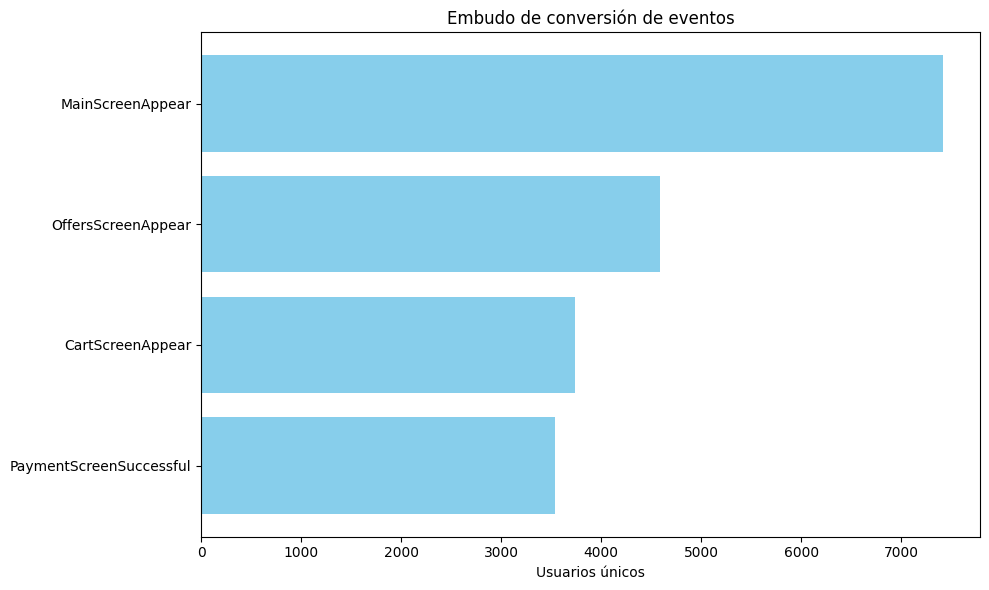

In [11]:
# Valores absolutos del embudo
etapas = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
usuarios = [
    df_filtrado[df_filtrado['event'] == 'MainScreenAppear']['user_id'].nunique(),
    df_filtrado[df_filtrado['event'] == 'OffersScreenAppear']['user_id'].nunique(),
    df_filtrado[df_filtrado['event'] == 'CartScreenAppear']['user_id'].nunique(),
    df_filtrado[df_filtrado['event'] == 'PaymentScreenSuccessful']['user_id'].nunique()
]

# Crear gráfica de embudo (gráfico de barras horizontales)
plt.figure(figsize=(10, 6))
plt.barh(etapas[::-1], usuarios[::-1], color='skyblue')  # Invertimos para que vaya de arriba hacia abajo
plt.xlabel('Usuarios únicos')
plt.title('Embudo de conversión de eventos')
plt.tight_layout()
plt.show()

## Paso 5 – Análisis del experimento A/A/B

En este paso se analizarán los resultados del experimento A/A/B realizado sobre los usuarios de la aplicación. El objetivo es evaluar si el cambio de tipografía propuesto (grupo 248) tuvo un impacto significativo en el comportamiento de los usuarios.

Los usuarios fueron divididos aleatoriamente en tres grupos:

- **Grupo 246 y Grupo 247**: grupos de control (misma fuente original).
- **Grupo 248**: grupo experimental (fuente nueva).

Este tipo de prueba incluye dos grupos A (control) para verificar que cualquier diferencia entre ellos sea estadísticamente insignificante, asegurando así que el experimento está correctamente diseñado. Si los dos grupos de control son similares, entonces cualquier diferencia entre los grupos A y B se puede atribuir al cambio de fuente.

En esta primera parte del paso 5, analizaremos:

- Cuántos usuarios hay en cada grupo.
- Si hay diferencias en comportamiento (eventos) entre los dos grupos de control (246 y 247).

Este análisis se hará exclusivamente con los datos del periodo confiable: del 1 al 7 de agosto de 2019.


In [12]:
# Contar cuántos usuarios únicos hay en cada grupo experimental

# Agrupamos por 'group' y usamos nunique para contar usuarios únicos
usuarios_por_grupo = df_filtrado.groupby('group')['user_id'].nunique().sort_index()

# Mostramos los resultados
print("Usuarios únicos por grupo experimental (del 1 al 7 de agosto):")
print(usuarios_por_grupo)


Usuarios únicos por grupo experimental (del 1 al 7 de agosto):
group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64


### Conclusión – Usuarios por grupo experimental

Durante el periodo del 1 al 7 de agosto de 2019, la cantidad de usuarios únicos en cada grupo fue la siguiente:

- Grupo 246 (control): 2,484 usuarios  
- Grupo 247 (control): 2,513 usuarios  
- Grupo 248 (experimental): 2,537 usuarios

La distribución entre los tres grupos es bastante equilibrada, lo que permite continuar con el análisis comparativo sin preocupaciones por sesgos en la asignación de usuarios.


### Comparación entre los grupos de control (246 vs 247)

Antes de analizar el grupo experimental, es fundamental asegurarnos de que los dos grupos de control (246 y 247) se comportan de manera similar. Si hay diferencias significativas entre ellos, podría indicar problemas en la segmentación del experimento.

En este paso se calculará la proporción de usuarios de cada grupo que realizaron cada tipo de evento. Luego, se aplicará una prueba estadística para determinar si estas diferencias son estadísticamente significativas.


In [13]:
# Filtrar solo los grupos de control (246 y 247)
control_df = df_filtrado[df_filtrado['group'].isin([246, 247])]

# Obtener usuarios únicos por grupo
usuarios_por_grupo_control = control_df.groupby('group')['user_id'].nunique()

# Calcular proporción de usuarios por evento en cada grupo
eventos = df_filtrado['event'].unique()

# Crear estructura para guardar proporciones
proporciones_control = {}

for evento in eventos:
    datos_evento = control_df[control_df['event'] == evento]
    usuarios_evento = datos_evento.groupby('group')['user_id'].nunique()
    
    proporciones = (usuarios_evento / usuarios_por_grupo_control) * 100
    proporciones_control[evento] = proporciones

# Mostrar proporciones por evento para cada grupo
for evento, proporciones in proporciones_control.items():
    print(f"\nEvento: {evento}")
    print(proporciones)



Evento: Tutorial
group
246    11.191626
247    11.261441
Name: user_id, dtype: float64

Evento: MainScreenAppear
group
246    98.631240
247    98.527656
Name: user_id, dtype: float64

Evento: OffersScreenAppear
group
246    62.077295
247    60.485476
Name: user_id, dtype: float64

Evento: CartScreenAppear
group
246    50.966184
247    49.263828
Name: user_id, dtype: float64

Evento: PaymentScreenSuccessful
group
246    48.309179
247    46.080382
Name: user_id, dtype: float64


### Conclusión – Comparación de proporciones entre grupos de control (246 vs 247)

Al comparar los grupos de control en términos de la proporción de usuarios que realizaron cada evento, se obtuvieron resultados muy similares:

- **Tutorial**: 11.19% (grupo 246) vs 11.26% (grupo 247)
- **MainScreenAppear**: 98.63% vs 98.53%
- **OffersScreenAppear**: 62.08% vs 60.49%
- **CartScreenAppear**: 50.97% vs 49.26%
- **PaymentScreenSuccessful**: 48.31% vs 46.08%

Estas diferencias son pequeñas, lo que sugiere que el comportamiento de ambos grupos es coherente. Sin embargo, para confirmar que las diferencias no son estadísticamente significativas, se aplicará una prueba de hipótesis.


### Pruebas de hipótesis entre grupos de control (246 vs 247)

Para confirmar si las diferencias observadas entre los grupos de control son estadísticamente significativas, aplicaremos una **prueba de hipótesis para dos proporciones (Z-test)** en cada evento.

Hipótesis nula (H₀): No hay diferencia significativa en la proporción de usuarios entre los grupos 246 y 247 para el evento.  
Hipótesis alternativa (H₁): Hay una diferencia significativa.

El nivel de significancia será **α = 0.05**.


In [14]:

# Definir eventos a evaluar
eventos = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']

# Obtener usuarios por grupo
usuarios_246 = control_df[control_df['group'] == 246]['user_id'].nunique()
usuarios_247 = control_df[control_df['group'] == 247]['user_id'].nunique()

# Evaluar cada evento
print("Pruebas Z de dos proporciones (grupo 246 vs 247):\n")

for evento in eventos:
    # Contar usuarios por grupo que realizaron el evento
    usuarios_evento_246 = control_df[(control_df['group'] == 246) & (control_df['event'] == evento)]['user_id'].nunique()
    usuarios_evento_247 = control_df[(control_df['group'] == 247) & (control_df['event'] == evento)]['user_id'].nunique()
    
    # Números de éxitos (usuarios que realizaron el evento) y tamaños de muestra
    successes = [usuarios_evento_246, usuarios_evento_247]
    samples = [usuarios_246, usuarios_247]
    
    # Prueba Z
    stat, pval = proportions_ztest(successes, samples)
    
    print(f"{evento}: p-valor = {pval:.4f} → {'Significativo' if pval < 0.05 else 'No significativo'}")


Pruebas Z de dos proporciones (grupo 246 vs 247):

MainScreenAppear: p-valor = 0.7571 → No significativo
OffersScreenAppear: p-valor = 0.2481 → No significativo
CartScreenAppear: p-valor = 0.2288 → No significativo
PaymentScreenSuccessful: p-valor = 0.1146 → No significativo
Tutorial: p-valor = 0.9377 → No significativo


### Conclusión – Pruebas estadísticas entre grupos de control (246 vs 247)

Se aplicó una prueba Z de dos proporciones para comparar los grupos de control en relación con la participación de usuarios en cada tipo de evento. Los resultados fueron:

- **MainScreenAppear**: p = 0.7571 → No significativo
- **OffersScreenAppear**: p = 0.2481 → No significativo
- **CartScreenAppear**: p = 0.2288 → No significativo
- **PaymentScreenSuccessful**: p = 0.1146 → No significativo
- **Tutorial**: p = 0.9377 → No significativo

Dado que en todos los casos los p-valores son superiores al umbral de significancia (0.05), no se encontraron diferencias estadísticamente significativas entre los grupos 246 y 247. Esto confirma que los grupos de control fueron bien segmentados y que se puede confiar en la validez del experimento A/A/B.


### Comparación del grupo experimental (248) con los grupos de control

Ahora que hemos validado que los grupos de control (246 y 247) se comportan de forma similar, vamos a comparar el **grupo experimental 248**, que recibió una fuente nueva, con:

- El grupo 246 (control individual)
- El grupo 247 (control individual)
- Ambos grupos de control combinados

Se calculará la proporción de usuarios que realizaron cada evento y se aplicará una prueba de hipótesis (Z-test) para determinar si existen diferencias estadísticamente significativas.


In [15]:
# Obtener usuarios únicos del grupo experimental
usuarios_248 = df_filtrado[df_filtrado['group'] == 248]['user_id'].nunique()

# Evaluar los mismos eventos que antes
eventos = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']

# Comparación entre grupo 248 y grupo 246
print("Comparación Grupo 248 vs Grupo 246\n")
for evento in eventos:
    u_248 = df_filtrado[(df_filtrado['group'] == 248) & (df_filtrado['event'] == evento)]['user_id'].nunique()
    u_246 = df_filtrado[(df_filtrado['group'] == 246) & (df_filtrado['event'] == evento)]['user_id'].nunique()
    
    successes = [u_248, u_246]
    samples = [usuarios_248, usuarios_246]
    
    stat, pval = proportions_ztest(successes, samples)
    print(f"{evento}: p-valor = {pval:.4f} → {'Significativo' if pval < 0.05 else 'No significativo'}")

# Comparación entre grupo 248 y grupo 247
print("\nComparación Grupo 248 vs Grupo 247\n")
for evento in eventos:
    u_248 = df_filtrado[(df_filtrado['group'] == 248) & (df_filtrado['event'] == evento)]['user_id'].nunique()
    u_247 = df_filtrado[(df_filtrado['group'] == 247) & (df_filtrado['event'] == evento)]['user_id'].nunique()
    
    successes = [u_248, u_247]
    samples = [usuarios_248, usuarios_247]
    
    stat, pval = proportions_ztest(successes, samples)
    print(f"{evento}: p-valor = {pval:.4f} → {'Significativo' if pval < 0.05 else 'No significativo'}")

# Comparación entre grupo 248 y grupos 246+247 combinados
print("\nComparación Grupo 248 vs Control Combinado (246 + 247)\n")

# Usuarios únicos combinados y por evento
usuarios_control = usuarios_246 + usuarios_247

for evento in eventos:
    u_248 = df_filtrado[(df_filtrado['group'] == 248) & (df_filtrado['event'] == evento)]['user_id'].nunique()
    u_246 = df_filtrado[(df_filtrado['group'] == 246) & (df_filtrado['event'] == evento)]['user_id'].nunique()
    u_247 = df_filtrado[(df_filtrado['group'] == 247) & (df_filtrado['event'] == evento)]['user_id'].nunique()
    
    u_control = u_246 + u_247
    
    successes = [u_248, u_control]
    samples = [usuarios_248, usuarios_control]
    
    stat, pval = proportions_ztest(successes, samples)
    print(f"{evento}: p-valor = {pval:.4f} → {'Significativo' if pval < 0.05 else 'No significativo'}")


Comparación Grupo 248 vs Grupo 246

MainScreenAppear: p-valor = 0.2950 → No significativo
OffersScreenAppear: p-valor = 0.2084 → No significativo
CartScreenAppear: p-valor = 0.0784 → No significativo
PaymentScreenSuccessful: p-valor = 0.2123 → No significativo
Tutorial: p-valor = 0.8264 → No significativo

Comparación Grupo 248 vs Grupo 247

MainScreenAppear: p-valor = 0.4587 → No significativo
OffersScreenAppear: p-valor = 0.9198 → No significativo
CartScreenAppear: p-valor = 0.5786 → No significativo
PaymentScreenSuccessful: p-valor = 0.7373 → No significativo
Tutorial: p-valor = 0.7653 → No significativo

Comparación Grupo 248 vs Control Combinado (246 + 247)

MainScreenAppear: p-valor = 0.2942 → No significativo
OffersScreenAppear: p-valor = 0.4343 → No significativo
CartScreenAppear: p-valor = 0.1818 → No significativo
PaymentScreenSuccessful: p-valor = 0.6004 → No significativo
Tutorial: p-valor = 0.7649 → No significativo


### Conclusión – Comparación del grupo experimental (248) con los grupos de control

Se realizaron pruebas Z de dos proporciones para comparar la proporción de usuarios que realizaron cada evento entre el grupo experimental (248) y los grupos de control (246 y 247), tanto individualmente como combinados.

En todos los casos, los **p-valores fueron superiores a 0.05**, por lo tanto **no se encontró evidencia estadística suficiente para rechazar la hipótesis nula**. Esto implica que **no hay diferencias significativas** entre los grupos.

#### Resultados por evento:

| Evento                  | 248 vs 246 | 248 vs 247 | 248 vs (246+247) |
|-------------------------|------------|------------|------------------|
| MainScreenAppear        | 0.2950     | 0.4587     | 0.2942           |
| OffersScreenAppear      | 0.2084     | 0.9198     | 0.4343           |
| CartScreenAppear        | 0.0784     | 0.5786     | 0.1818           |
| PaymentScreenSuccessful | 0.2123     | 0.7373     | 0.6004           |
| Tutorial                | 0.8264     | 0.7653     | 0.7649           |

### Conclusión 

El cambio de fuente no tuvo un efecto estadísticamente significativo en el comportamiento de los usuarios dentro de la aplicación. Por lo tanto, no hay evidencia para afirmar que la nueva fuente afecte negativamente (ni positivamente) la interacción de los usuarios.


## Conclusión General del Análisis

A lo largo del análisis del comportamiento de usuarios en la aplicación, se abordaron dos objetivos principales: el estudio del embudo de ventas y la evaluación del experimento A/A/B sobre el cambio de fuente.

### 1. Análisis del embudo de eventos

- Se identificó una secuencia lógica de eventos desde la pantalla principal hasta la compra.
- El embudo mostró que el **98%** de los usuarios llegan a la pantalla principal, pero solo un **46.97%** completan una compra.
- La mayor pérdida de usuarios ocurre entre la pantalla principal y la de ofertas.
- Una vez que el usuario llega al carrito, la conversión a compra es alta (**94.78%**), lo cual indica que los usuarios con intención de compra completan el proceso con éxito.

### 2. Evaluación del experimento A/A/B

- Se validó que los grupos de control (246 y 247) no presentan diferencias significativas, lo que confirma la integridad del diseño experimental.
- Al comparar el grupo experimental (248) con los controles, **no se encontraron diferencias estadísticamente significativas** en ninguna de las métricas evaluadas.
- Esto sugiere que el cambio de fuente no afecta de manera relevante la interacción de los usuarios con la aplicación.

### Conclusión Final

El embudo de conversión es funcional y eficiente a partir del momento en que el usuario agrega productos al carrito. El experimento A/A/B indica que el cambio de fuente no representa un riesgo para la experiencia del usuario, por lo que podría implementarse sin afectar negativamente el comportamiento dentro de la app.
